In [55]:
# [ python 3.12 ]
# !conda create -n ai_env python=3.12 -y
# !conda activate ai_env

In [56]:
# !pip install numpy pandas matplotlib seaborn -q

In [ ]:
# !pip install ipykernel scikit-learn tqdm -q

In [ ]:
# !pip install statsmodels -q

^C


In [59]:
#### linux 버전 확인용
# !pip install distro -q

In [60]:
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## 1. Import

In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# 한글 폰트 설정
import matplotlib
import matplotlib.font_manager as fm
import platform

# OS 정보
os_name = platform.system()         # Windows / Linux / Darwin
os_version = platform.release()     # 11, 8.1, 22.04 등은 직접 매핑 필요

"""
OS	            NT 버전 (platform.version()의 major.minor 부분)	대표 빌드 번호
Windows 8.0	    6.2	                                            9200
Windows 8.1	    6.3	                                            9600
Windows 10	    10.0	                                        10240 ~ 19045
Windows 11	    10.0	                                        22000 / 22621 / 22631 / 26100
""" 

# C:\Windows\Fonts   # ==> Windows OS에 등록되어 있는 모든 폰트 파일들
if os_name == "Windows":
    # Windows 11 / Windows 8.1 구분하기
    # platform.release()가 10으로 나오는 경우도 있어 version() 검사 필요
    version_detail = platform.version()

    if "10.0" in version_detail:
        # Windows 11 or Windows 10 버전: 10.0
        print("→ Windows 11 (or 10) detected")
        font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS, Windows11 폰트 경로

    elif "6.3" in version_detail:
        # Windows 8.1 버전: 6.3
        print("→ Windows 8.1 detected")
        font_path = 'C:\\Windows\\Fonts\\batang.ttc' # 윈도우 OS, Windows8.1 폰트 경로

    else:
        print("→ Unknown Windows version:", version_detail)
        
# '~/.local/share/fonts/' or '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 22.04 폰트 경로
elif os_name == "Linux":
    # Ubuntu 버전 확인
    import distro   # pip install distro (필요 시)

    linux_name = distro.name()
    linux_version = distro.version()

    if linux_name == "Ubuntu" and linux_version.startswith("22.04"):
        print("→ Ubuntu 22.04 detected")
        font_path = '/home/yypark/.local/share/fonts/D2Coding-Ver1.3.2-20180524.ttf' # Ubuntu 22.04 폰트 경로
    else:
        print(f"→ Other Linux distro: {linux_name} {linux_version}")
        font_path = '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 폰트 경로

else:
    print("Unsupported OS:", os_name)
    

font_prop = fm.FontProperties(fname = font_path) # 폰트경로에 있는 폰트 이름들 뽑아오자.
font_name = font_prop.get_name() # 폰트명

#matplotlib.rc('font', key=value)
matplotlib.rc('font', family=font_name)

# matplotlib이 기본적으로 사용하는 유니코드 마이너스 비활성화
# -> 아스키코드의 마이너스 사용
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지

→ Windows 11 (or 10) detected


In [64]:
def safe_corr(x, y):
    """_summary_

    Args:
        x (_type_): _description_
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 1 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs



In [65]:
#####  기본값: find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4)
def find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 0 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_lag (int, optional): _description_. Defaults to 1.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            ## lag = 1 ~ max_lag 탐색
            #for lag in range(1, max_lag + 1):
            # lag = 0 ~ max_lag 탐색
            for lag in range(min_lag, max_lag + 1):
                if n_months <= lag:
                    continue
                if lag == 0: corr = safe_corr(x[:], y[lag:])
                else: corr = safe_corr(x[:-lag], y[lag:])
                
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs


In [66]:

def plot_histogram(input_var_col: pd.Series|pd.DataFrame, num_bin: int,
                    title_str: str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                    xlbl_str: str = 'following_item 갯수',
                    verbose=False):
    
    if type(input_var_col) == pd.Series: ser = input_var_col
    elif type(input_var_col) == pd.DataFrame: ser = input_var_col.squeeze(axis=1)
    else: 
        print("Wrong input: input should be pd.Series or pd.DataFrame of single column")
        return 
    
    #fig = plt.figure(figsize=(10,10))
    #df_pairs_mod.plot(kind='hist', bins=10)
    # (최대값 - 최소값) / bins
    # plt.hist(scores, bins =10) # bins = 10, 기본값
    count, bins, container = plt.hist(ser, bins=num_bin, edgecolor='k', rwidth=.9) # 
    if verbose:
        print('count :', count) # count : [    1.   2.   1.     3.   3.     3.   2.     5.]
        print('bins :', bins)   # bins :  [60. 64.25 68.5  72.75 77.   81.25 85.5  89.75 94.  ]
        print('container :', container) # container : <BarContainer object of 8 artists>
        for i in range(len(bins)-1):
            print(f'{bins[i]} ~ {bins[i+1]} : {int(count[i])}개')

    plt.xlabel(xlbl_str)
    plt.ylabel('Count')
    #plt.ylim([0, 20])
    #plt.yticks([0, 3, 6, 9, 12, 15, 18])
    plt.grid(axis='y')

    plt.title(title_str)
    plt.show()

In [67]:
def build_training_data(pivot, pairs):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

In [68]:
def build_training_data_fe(pivot, pairs, add_fe = ['wv_cat', 'seq_cat', 'hs4_cat']):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수 
    + engineered feature 추가
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
      - add_fe = ['wv_cat']
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        # add Feat.Eng.
        wv_cat = int(row.wv_cat)
        seq_cat = int(row.seq_cat)
        hs4_cat = int(row.hs4_cat)
          

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "wv_cat": float(wv_cat),
                "seq_cat": float(seq_cat),
                "hs4_cat": float(hs4_cat),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

In [69]:
def predict(pivot, pairs, reg):
    """_summary_

    Args:
        pivot (_type_): _description_
        pairs (_type_): _description_
        reg (_type_): _description_

    Returns:
        _type_: _description_
    """
    months = pivot.columns.to_list()
    n_months = len(months) # 43

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1 # 42 as index (43 months 경우)
    t_prev = n_months - 2 # 41 as index (43 months 경우)

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        ##### features added other than 'value'
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            ##### 기본값 설정필요
            continue

        a_series = pivot.loc[leader].values.astype(float)   # Leader TS
        b_series = pivot.loc[follower].values.astype(float) # Follower TS

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            ##### 기본값 설정필요
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        y_pred = reg.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [70]:
def predict_fe(pivot, pairs, reg, add_fe = ['wv_cat', 'seq_cat', 'hs4_cat']):
    """_summary_

    Args:
        pivot (_type_): _description_
        pairs (_type_): _description_
        reg (_type_): _description_

    Returns:
        _type_: _description_
    """
    months = pivot.columns.to_list()
    n_months = len(months) # 43

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1 # 42 as index (43 months 경우)
    t_prev = n_months - 2 # 41 as index (43 months 경우)

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        ##### features added other than 'value'
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        wv_cat = int(row.wv_cat)
        seq_cat = int(row.seq_cat)
        hs4_cat = int(row.hs4_cat)

        if leader not in pivot.index or follower not in pivot.index:
            ##### 기본값 설정필요
            continue

        a_series = pivot.loc[leader].values.astype(float)   # Leader TS
        b_series = pivot.loc[follower].values.astype(float) # Follower TS

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            ##### 기본값 설정필요
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat)]])     
        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat), float(seq_cat)]])     
        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat), float(seq_cat), float(hs4_cat)]])    
        y_pred = reg.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [71]:
def predict_local(pivot, pairs, reg):
    pass

In [72]:
def _validate_input(answer_df, submission_df):
    # ① 컬럼 개수·이름 일치 여부
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")


    # ② 필수 컬럼에 NaN 존재 여부
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # ③ pair 중복 여부
    pairs = list(zip(submission_df["leading_item_id"], submission_df["following_item_id"]))
    if len(pairs) != len(set(pairs)):
        raise ValueError("The submission dataframe contains duplicate (leading_item_id, following_item_id) pairs.")


def comovement_f1(answer_df, submission_df):
    """공행성쌍 F1 계산"""
    ans = answer_df[["leading_item_id", "following_item_id"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])


    tp = len(G & P)
    fp = len(P - G)
    fn = len(G - P)


    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0


    return f1



def comovement_nmae(answer_df, submission_df, eps=1e-6):
    """
    전체 U = G ∪ P에 대한 clipped NMAE 계산
    """
    ans = answer_df[["leading_item_id", "following_item_id", "value"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id", "value"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])
    U = G | P


    ans_val = dict(zip(ans["pair"], ans["value"]))
    sub_val = dict(zip(sub["pair"], sub["value"]))


    errors = []
    for pair in U:
        if pair in G and pair in P:
            # 정수 변환(반올림) (b/c 무역량은 정수)
            y_true = int(round(float(ans_val[pair])))
            y_pred = int(round(float(sub_val[pair])))
            rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
            rel_err = min(rel_err, 1.0) # 오차 100% 이상은 100%로 간주
        else:
            rel_err = 1.0  # FN, FP는 오차 100%
        errors.append(rel_err)


    return np.mean(errors) if errors else 1.0


def comovement_score(answer_df, submission_df):
    _validate_input(answer_df, submission_df)
    S1 = comovement_f1(answer_df, submission_df)
    nmae_full = comovement_nmae(answer_df, submission_df, 1e-6)
    S2 = 1 - nmae_full
    score = 0.6 * S1 + 0.4 * S2
    return score


In [73]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


def local_MAE(y_true, y_pred, eps=1e-6):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형"""
        # 정수 변환(반올림) (b/c 무역량은 정수)
    y_true = int(round(float(y_true)))
    y_pred = int(round(float( y_pred)))
    abs_err = abs(y_true - y_pred)
    return abs_err


def local_MAPE1(y_true, y_pred, eps=1e-6):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형
        the percentage in the range [0, 100] is converted to a relative value in the range [0, 1] by dividing by 100. 
        Thus, an error of 200% corresponds to a relative error of 2.
    """
        # 정수 변환(반올림) (b/c 무역량은 정수)
    y_true = np.round(y_true.astype(float)).astype(int)
    y_pred = np.round(y_pred.astype(float)).astype(int)
    #rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
    ##rel_err = min(rel_err, 1.0) # 오차 100% 이상은 100%로 간주
    ##return rel_err if rel_err else 1.0
    #return min(rel_err, 1.0)
    rel_err = np.abs(y_true - y_pred) / (np.abs(y_true) + eps)
    #return np.sum(np.where(rel_err < 1.0, rel_err, 1.0))/len(rel_err)
    return np.mean(np.where(rel_err < 1.0, rel_err, 1.0))


def local_MAPE2(y_true, y_pred):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형
        scikit-learn  mean_absolute_percentage_error()이용
        an error of 200% corresponds to a relative error of 2. ==> maybe wrong (element-wise min(x, 1)필요).
    """
    #return np.mean(min(mean_absolute_percentage_error(y_true, y_pred), 1)) # 오차 100% 이상은 100%로 간주  ==> maybe wrong (element-wise min(x, 1)필요).
    return mean_absolute_percentage_error(y_true, y_pred) 


    

## 0.  파라미터 설정

In [74]:
# a) 공햏성쌍 탐색 함수 파라미터 세팅 (default: min_lag=1, max_lag=6, min_nonzero=12, corr_threshold=0.4)
min_lag=1
max_lag=6 
min_nonzero=12 
corr_threshold=0.4

# b) LinearRegression 모델 파라미터 세팅(defaut: )

# 설정파라미터 로깅
EXP_LOG = {} # 테스트 파라미터 값 저장 딕셔너리 ==> 일단 이건 고정하고, feat.eng.와 model에 변화주며 테스팅
EXP_LOG['min_lag'] = 1
EXP_LOG['max_lag'] = 6
EXP_LOG['min_nonzero'] = 12
EXP_LOG['corr_threshold'] = 0.4

## 1. 무역 데이터 로딩

### train.csv

In [75]:
train = pd.read_csv('./data/train.csv')
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0


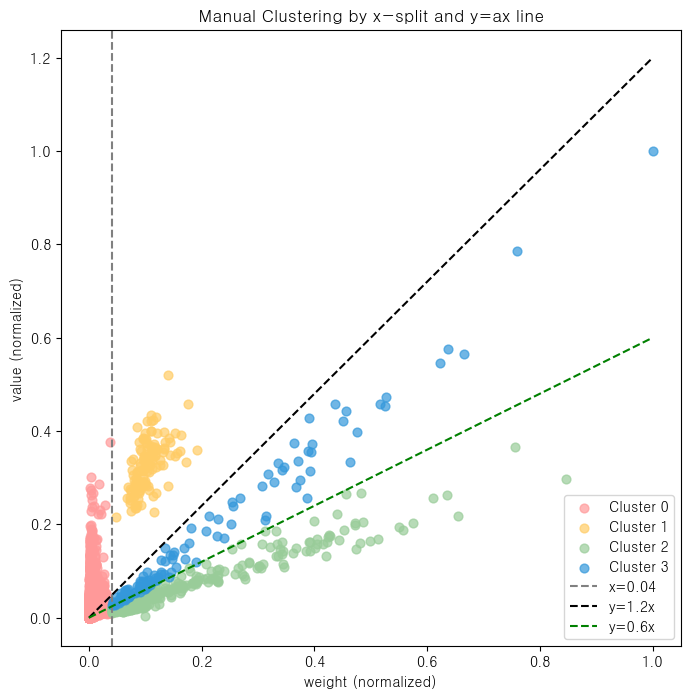

In [76]:
######
###### feature engineering 1:  weight-value categorizattion via manual clustering
######

# 최대 weight 값 기준 정규화 (0~1 범위로 맞추면 시각화 깔끔)
x = train['weight'] / train['weight'].max()
y = train['value'] / train['value'].max()

# 기준선 설정
x_split = 0.04     # x=0.3 경계선
a = 1.2            # y = a*x 기준선 (기울기)
b = 0.6            # y = b*x 기준선 (기울기)
train['cluster_manual'] = 0  # 기본값


#plt.imshow((x > x_split) & (y > a * x))



# 조건별 군집 분류
train.loc[(x <= x_split), 'cluster_manual'] = 0 # 분홍색 군집
train.loc[(x > x_split) & (y > a * x), 'cluster_manual'] = 1 # 노란색 군집
train.loc[(x > x_split) & (y <= a * x), 'cluster_manual'] = 2 # 초록색 군집
train.loc[(x > x_split) & (y <= a * x) & (y >= b * x), 'cluster_manual'] = 3 # 파란색 군집
############################################################################
# 시각화
plt.figure(figsize=(8,8))
colors = ['#FF9999','#FFCC66','#99CC99', '#3498db']
for i, color in enumerate(colors):
    plt.scatter(x[train['cluster_manual']==i],
                y[train['cluster_manual']==i],
                label=f'Cluster {i}', s=40, color=color, alpha=0.7)


# 기준선들 시각화
plt.axvline(x=x_split, color='gray', linestyle='--', label=f'x={x_split}')
plt.plot(np.linspace(0,1,100),
         a * np.linspace(0,1,100),
         color='black', linestyle='--', label=f'y={a}x')
plt.plot(np.linspace(0,1,100),
         b * np.linspace(0,1,100),
         color='green', linestyle='--', label=f'y={b}x')

plt.xlabel('weight (normalized)')
plt.ylabel('value (normalized)')
plt.title('Manual Clustering by x-split and y=ax line')
plt.legend()
plt.show()

In [77]:
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value,cluster_manual
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,0


In [78]:
#train.groupby(['item_id' ,'cluster_manual'])['item_id'].size()
print(train.groupby('cluster_manual')['item_id'].apply(lambda x: len(np.unique(x))))
train.groupby('cluster_manual')['item_id'].apply(lambda x: np.unique(x))

cluster_manual
0    99
1     1
2     7
3     4
Name: item_id, dtype: int64


cluster_manual
0    [AANGBULD, AHMDUILJ, ANWUJOKX, APQGTRMF, ATLDM...
1                                           [FCYBOAXC]
2    [ATLDMDBO, BTMOEMEP, HXYSSRXE, LLHREMKS, LRVGF...
3             [ATLDMDBO, BTMOEMEP, LRVGFDFM, SDWAYPIK]
Name: item_id, dtype: object

In [79]:
tmp_df_seq = train.groupby(["cluster_manual"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['cluster_manual_len'] = train.groupby(["cluster_manual"])["item_id"].apply(lambda x: len(np.unique(x))).values#['item_id']#.sort_values(by='item_id', ascending=False, key = lambda x: len(x), axis=1)#.reset_index(drop=True)['item_id']
tmp_df_seq

dct_seq_cat = tmp_df_seq[['cluster_manual','item_id']].set_index('cluster_manual').to_dict()['item_id']
dct_seq_cat

{0: array(['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO',
        'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC',
        'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU',
        'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE',
        'EVBVXETX', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI',
        'FTSVTTSR', 'FWUCPMMW', 'GIKPEWTY', 'GKQIJYDH', 'GMBFCMIU',
        'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY',
        'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO',
        'KFQSHBNH', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM',
        'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV',
        'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS',
        'OXKURKXR', 'PLMZALFA', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB',
        'QRKRBYJL', 'QSDCUCLB', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM',
        'RJCAXSGH', 'RJGPVEXX', 'ROACSLMG', 'RUVXNNVA', 'SAAYMURU',
        'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', '

In [80]:
len(set(dct_seq_cat[0])), len(set(dct_seq_cat[1])), len(set(dct_seq_cat[2])), len(set(dct_seq_cat[3]))

(99, 1, 7, 4)

In [81]:
print(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[1]))) # 중복 없음
print(sorted(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[2])))) # ['ATLDMDBO', 'BTMOEMEP', 'HXYSSRXE', 'LLHREMKS', 'LRVGFDFM', 'SDWAYPIK', 'XMKRPGLB']
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[2]))) # 중복 없음
print(sorted(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[3])))) # ['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[3]))) # 중복 없음
print(sorted(set(dct_seq_cat[2]).intersection(set(dct_seq_cat[3])))) # ['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']

set()
['ATLDMDBO', 'BTMOEMEP', 'HXYSSRXE', 'LLHREMKS', 'LRVGFDFM', 'SDWAYPIK', 'XMKRPGLB']
set()
['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']
set()
['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']


In [82]:
dct_wv_cat_inv = {1:['FCYBOAXC'], 
              2:['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK'], 
              3:['HXYSSRXE', 'LLHREMKS', 'XMKRPGLB'], 
              4:sorted(set(dct_seq_cat[0]).difference(set(dct_seq_cat[2]))) }
dct_wv_cat_inv[4][:10]

['AANGBULD',
 'AHMDUILJ',
 'ANWUJOKX',
 'APQGTRMF',
 'AXULOHBQ',
 'BEZYMBBT',
 'BJALXPFS',
 'BLANHGYY',
 'BSRMSVTC',
 'BUZIIBYG']

In [83]:
dct_wv_cat = {}
for k, v in dct_wv_cat_inv.items():
    for item in v:
        dct_wv_cat[item] = k
len(dct_wv_cat) # fe-weight-value cat. dictionary

100

In [84]:
######
###### feature engineering 2:  seq-item_id categorization
######

seq_pivot_df_cnt = pd.pivot_table(train, index='item_id', columns="month", values='seq',aggfunc='count', margins=True, margins_name="seq_total")

tmp_ser = seq_pivot_df_cnt['seq_total'].iloc[:-1]
dct_seq_total = pd.cut(tmp_ser, bins= [0, 40, 80, tmp_ser.max()], labels = ['seq_cnt_low',  'seq_cnt_mid',  'seq_cnt_high'] ).to_dict()
dct_seq_total

train['seq_cat'] = train["item_id"].map(dct_seq_total)
display(train.head(3))

tmp_df_seq = train.groupby(["seq_cat"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['seq_cat_len'] = train.groupby(["seq_cat"])["item_id"].apply(lambda x: len(np.unique(x))).values

dct_seq_cat_inv = tmp_df_seq[['seq_cat','item_id']].set_index('seq_cat').to_dict()['item_id']
dct_seq_cat_inv


,item_id,year,month,seq,type,hs4,weight,quantity,value,cluster_manual,seq_cat
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,0,seq_cnt_high
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,0,seq_cnt_high
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,0,seq_cnt_high


{'seq_cnt_high': array(['AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT',
        'BJALXPFS', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF',
        'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DNMPSKTB', 'DUCMGGNW',
        'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN',
        'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'GKQIJYDH', 'GYHKIVQT',
        'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW',
        'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR',
        'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML',
        'LUENUFGA', 'MBSBZBXA', 'NZKBIBNU', 'OJIFIHMZ', 'OKMBFVKS',
        'OXKURKXR', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE',
        'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU',
        'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP',
        'UGEQLMXM', 'UIFPPCLR', 'UQYUIVVR', 'UXSPKBJR', 'VBYCLTYZ',
        'VMAQSTJE', 'VUAFAIYJ', 'VWMBASNE', 'WBLJNPZQ', 'WHPUAOID',
        'WPQXWHYO', 'WQMVCOEM', 

In [85]:
dct_seq_cat = {}
for k, v in dct_seq_cat_inv.items():
    for item in v:
        if k=="seq_cnt_low": dct_seq_cat[item] = 1
        elif k=="seq_cnt_mid": dct_seq_cat[item] = 2
        elif k=="seq_cnt_high": dct_seq_cat[item] = 3
len(dct_seq_cat) # fe-seq-item_id cat. dictionary

100

In [86]:
######
###### feature engineering 3:  seq-item_id categorization
######

tmp_df = train.groupby(["hs4"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df['item_id_len'] = train.groupby(["hs4"], as_index=False)["item_id"].apply(lambda x: len(np.unique(x)))['item_id']
hs4_tmp_df = tmp_df.sort_values(by='item_id_len', ascending=False).reset_index(drop=True)
display(hs4_tmp_df.head(20))
print(hs4_tmp_df['hs4'][:20].values) # [2805 3824 8501 2811 8102 8505 3815 2807 7207 2846 3102 2529 8714 1210 2002 2701 2612 2501 2102 2836]
print(hs4_tmp_df.shape) # (71, 3)
hs4_tmp_df['item_id_len'][:20].sum() # 49

,hs4,item_id,item_id_len
0,2805,"[BSRMSVTC, DJBLNPNC, RCBZUSIM, SUOYXCHP, WQMVC...",6
1,3824,"[FCYBOAXC, IGDVVKUD, LPHPPJUG, PYZMVUWD, SNHYO...",5
2,8501,"[GKQIJYDH, KFQSHBNH, QKXNTIIB, RJCAXSGH, UQYUI...",5
3,2811,"[DNMPSKTB, RJGPVEXX, VWMBASNE, WPQXWHYO]",4
4,8102,"[FQCLOEXA, KEUWZRKO, UIFPPCLR]",3
5,8505,"[GYHKIVQT, ROACSLMG, VBYCLTYZ]",3
6,3815,"[OJIFIHMZ, STZDBITS, XIIEJNEE]",3
7,2807,"[DDEXPPXU, LLHREMKS, YSYHGLQK]",3
8,7207,"[SDWAYPIK, TGOELCAG]",2
9,2846,"[FRHNWLNI, MBSBZBXA]",2


[2805 3824 8501 2811 8102 8505 3815 2807 7207 2846 3102 2529 8714 1210
 2002 2701 2612 2501 2102 2836]
(71, 3)


np.int64(49)

In [87]:
# for i, row in enumerate(hs4_tmp_df):
#     print(i, row)
#     #break

tmp_seq = [ x if x < 14 else 14 for x in range(1, len(hs4_tmp_df)+1) ]
hs4_tmp_df['hs4_cat'] = tmp_seq
pd.concat([hs4_tmp_df.head(15), hs4_tmp_df.tail(5)])


,hs4,item_id,item_id_len,hs4_cat
0,2805,"[BSRMSVTC, DJBLNPNC, RCBZUSIM, SUOYXCHP, WQMVC...",6,1
1,3824,"[FCYBOAXC, IGDVVKUD, LPHPPJUG, PYZMVUWD, SNHYO...",5,2
2,8501,"[GKQIJYDH, KFQSHBNH, QKXNTIIB, RJCAXSGH, UQYUI...",5,3
3,2811,"[DNMPSKTB, RJGPVEXX, VWMBASNE, WPQXWHYO]",4,4
4,8102,"[FQCLOEXA, KEUWZRKO, UIFPPCLR]",3,5
5,8505,"[GYHKIVQT, ROACSLMG, VBYCLTYZ]",3,6
6,3815,"[OJIFIHMZ, STZDBITS, XIIEJNEE]",3,7
7,2807,"[DDEXPPXU, LLHREMKS, YSYHGLQK]",3,8
8,7207,"[SDWAYPIK, TGOELCAG]",2,9
9,2846,"[FRHNWLNI, MBSBZBXA]",2,10


In [88]:
cp_hs4_tmp_df = hs4_tmp_df[['hs4_cat','item_id']].copy()
print(cp_hs4_tmp_df[hs4_tmp_df['hs4_cat']==14].shape)
lst_hs4_cat14 = []
for item in cp_hs4_tmp_df[hs4_tmp_df['hs4_cat']==14]['item_id']:
    lst_hs4_cat14.append(item.tolist()[0])
    
print(len(lst_hs4_cat14))
lst_hs4_cat14



(58, 2)
58


['JBVHSUWY',
 'ELQGMQWE',
 'FWUCPMMW',
 'RUVXNNVA',
 'XIPPENFQ',
 'AHMDUILJ',
 'HXYSSRXE',
 'QRKRBYJL',
 'BJALXPFS',
 'ATLDMDBO',
 'DEWLVASR',
 'PLMZALFA',
 'ZGJXVMNI',
 'UXSPKBJR',
 'QJQJSWFU',
 'EVBVXETX',
 'BEZYMBBT',
 'SAAYMURU',
 'NAQIHUKZ',
 'DUCMGGNW',
 'JPBRUTWP',
 'RAWUKQMJ',
 'GMBFCMIU',
 'SAHWCZNH',
 'LUENUFGA',
 'QSDCUCLB',
 'MIRCVAMV',
 'ANWUJOKX',
 'TANNMIMB',
 'QVLMOEYE',
 'LTOYKIML',
 'JERHKLYW',
 'AANGBULD',
 'ZXERAXWP',
 'WHPUAOID',
 'AXULOHBQ',
 'DBWLZWNK',
 'LSOIUSXD',
 'JSLXRQOK',
 'XUOIQPFL',
 'WBLJNPZQ',
 'OXKURKXR',
 'CCLHWFWF',
 'VUAFAIYJ',
 'HCDTGMST',
 'OKMBFVKS',
 'NZKBIBNU',
 'FDXPMYGF',
 'OGAFEHLU',
 'GIKPEWTY',
 'KAGJCHMR',
 'ZCELVYQU',
 'APQGTRMF',
 'KJNSOAHR',
 'VMAQSTJE',
 'XIFHSOWQ',
 'BLANHGYY',
 'BUZIIBYG']

In [89]:
dct_hs4_cat_inv = hs4_tmp_df[['hs4_cat','item_id']][:13].set_index('hs4_cat').to_dict()['item_id']
dct_hs4_cat_inv[14] = np.array(lst_hs4_cat14)
dct_hs4_cat_inv

{1: array(['BSRMSVTC', 'DJBLNPNC', 'RCBZUSIM', 'SUOYXCHP', 'WQMVCOEM',
        'ZKENOUDA'], dtype=object),
 2: array(['FCYBOAXC', 'IGDVVKUD', 'LPHPPJUG', 'PYZMVUWD', 'SNHYOVBM'],
       dtype=object),
 3: array(['GKQIJYDH', 'KFQSHBNH', 'QKXNTIIB', 'RJCAXSGH', 'UQYUIVVR'],
       dtype=object),
 4: array(['DNMPSKTB', 'RJGPVEXX', 'VWMBASNE', 'WPQXWHYO'], dtype=object),
 5: array(['FQCLOEXA', 'KEUWZRKO', 'UIFPPCLR'], dtype=object),
 6: array(['GYHKIVQT', 'ROACSLMG', 'VBYCLTYZ'], dtype=object),
 7: array(['OJIFIHMZ', 'STZDBITS', 'XIIEJNEE'], dtype=object),
 8: array(['DDEXPPXU', 'LLHREMKS', 'YSYHGLQK'], dtype=object),
 9: array(['SDWAYPIK', 'TGOELCAG'], dtype=object),
 10: array(['FRHNWLNI', 'MBSBZBXA'], dtype=object),
 11: array(['BTMOEMEP', 'LRVGFDFM'], dtype=object),
 12: array(['FTSVTTSR', 'XMKRPGLB'], dtype=object),
 13: array(['FITUEHWN', 'UGEQLMXM'], dtype=object),
 14: array(['JBVHSUWY', 'ELQGMQWE', 'FWUCPMMW', 'RUVXNNVA', 'XIPPENFQ',
        'AHMDUILJ', 'HXYSSRXE', 'QRKRBYJL', 'BJ

In [90]:
dct_hs4_cat = {}
for k, v in dct_hs4_cat_inv.items():
    for item in v:
        dct_hs4_cat[item] = k
print(len(dct_hs4_cat)) # fe-hs4-item_id cat. dictionary
#dct_hs4_cat

100


### monthly data


In [91]:
# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

monthly.head()

,item_id,year,month,value,ym
0,AANGBULD,2022,1,14276.0,2022-01-01
1,AANGBULD,2022,2,52347.0,2022-02-01
2,AANGBULD,2022,3,53549.0,2022-03-01
3,AANGBULD,2022,5,26997.0,2022-05-01
4,AANGBULD,2022,6,84489.0,2022-06-01


### pivot

In [92]:
# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot_org = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print("pivot_org.shape: ", pivot_org.shape)
pivot_org.head()

pivot_org.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [93]:
##### 로컬 테스팅을 위해, pivot.iloc[:, :-1]과 pivot.iloc[:, [-1]]로  split
target_pivot = pivot_org.iloc[:, [-1]].copy()
pivot = pivot_org.iloc[:, :-1].copy()

print("pivot.shape: ", pivot.shape)
pivot.head(3)

pivot.shape:  (100, 42)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,313076.0,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,184920.0,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# dictionary of "item_id": y_true value:
target_pivot.head()
target_pivot.to_dict().keys()#['2025-07-01 00:00:00']
dct_y_true = target_pivot.to_dict()[pd.to_datetime('2025-07-01')]

for k,v in dct_y_true.items():
    if v==0: print(k, v)

ANWUJOKX 0.0
GIKPEWTY 0.0
GMBFCMIU 0.0
HCDTGMST 0.0
NAQIHUKZ 0.0
OGAFEHLU 0.0
PLMZALFA 0.0
QSDCUCLB 0.0
RUVXNNVA 0.0
TANNMIMB 0.0


## 2. 공행성쌍 탐색

In [95]:
pairs = find_comovement_pairs(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
print("탐색된 공행성쌍 수:", len(pairs)) # 탐색된 공행성쌍 수: 1425

EXP_LOG["탐색된 공행성쌍 pairs.shape"] = pairs.shape
pairs.head()

0it [00:00, ?it/s]

100it [00:07, 13.79it/s]

탐색된 공행성쌍 수: 1425


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,5,-0.443984
1,AANGBULD,DEWLVASR,6,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635
3,AANGBULD,EVBVXETX,6,0.436623
4,AANGBULD,FTSVTTSR,3,0.531400


In [96]:
pairs['max_corr_abs'] = pairs['max_corr'].apply(np.abs)
pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   leading_item_id    1425 non-null   object 
 1   following_item_id  1425 non-null   object 
 2   best_lag           1425 non-null   int64  
 3   max_corr           1425 non-null   float64
 4   max_corr_abs       1425 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 55.8+ KB


In [97]:
df_pairs = pairs.groupby('leading_item_id')['following_item_id'] \
    .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
df_pairs    

###
### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
###

dct_pair_detection = {'comv_yes':df_pairs.index.to_list() , 
                      'comv_no': set(train['item_id']).difference(set(df_pairs.index.to_list()))}
print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_detection['comv_no']))
print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_detection['comv_no']))

print("공행성 탐지된 상품수: ", len(dct_pair_detection['comv_yes']))
print("공행성이 탐지된 상품id: ", sorted(dct_pair_detection['comv_yes'])) 
### logging
EXP_LOG["공행성이 탐지되지 않은 상품수"] = len(dct_pair_detection['comv_no'])
EXP_LOG["공행성이 탐지되지 않은 상품id:"] = sorted(dct_pair_detection['comv_no'])
EXP_LOG["공행성이 탐지된 상품수"] = len(dct_pair_detection['comv_yes'])

공행성이 탐지되지 않은 상품수:  9
공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  91
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

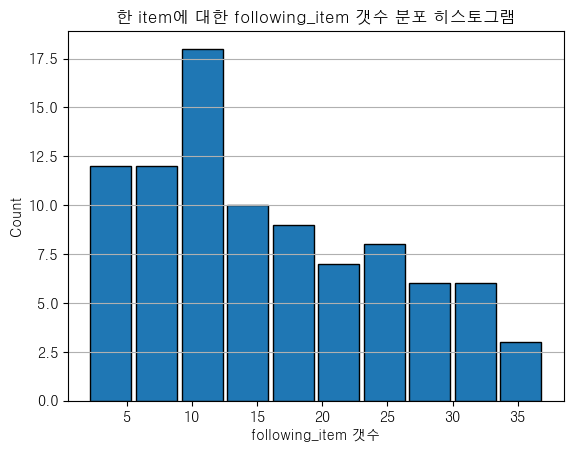

In [98]:
plot_histogram(input_var_col = df_pairs['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

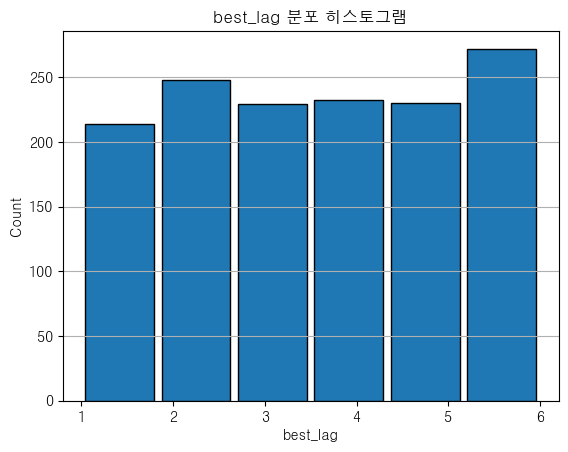

In [99]:
plot_histogram(input_var_col = pairs['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [100]:
##### answer_df 생성
display(pairs.head(3))
answer_df = pairs[['leading_item_id', 'following_item_id']].copy()

display(answer_df)
answer_df['value'] = answer_df['following_item_id'].apply(lambda x: dct_y_true[x])
answer_df.head()

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs
0,AANGBULD,APQGTRMF,5,-0.443984,0.443984
1,AANGBULD,DEWLVASR,6,0.640221,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635,0.410635


,leading_item_id,following_item_id
0,AANGBULD,APQGTRMF
1,AANGBULD,DEWLVASR
2,AANGBULD,DNMPSKTB
3,AANGBULD,EVBVXETX
4,AANGBULD,FTSVTTSR
...,...,...
1420,ZXERAXWP,DBWLZWNK
1421,ZXERAXWP,FITUEHWN
1422,ZXERAXWP,MIRCVAMV
1423,ZXERAXWP,UIFPPCLR


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,40608.0
1,AANGBULD,DEWLVASR,482787.0
2,AANGBULD,DNMPSKTB,4507669.0
3,AANGBULD,EVBVXETX,5061099.0
4,AANGBULD,FTSVTTSR,246916.0


In [101]:
for gn, gdf in answer_df.groupby('following_item_id'):
    print("group name: ", gn)
    print("group dataframe: \n", gdf)
    break

group name:  AANGBULD
group dataframe: 
      leading_item_id following_item_id     value
286         DNMPSKTB          AANGBULD  533478.0
326         ELQGMQWE          AANGBULD  533478.0
448         GYHKIVQT          AANGBULD  533478.0
595         KAGJCHMR          AANGBULD  533478.0
628         LLHREMKS          AANGBULD  533478.0
747         NZKBIBNU          AANGBULD  533478.0
879         QRKRBYJL          AANGBULD  533478.0
973         RJGPVEXX          AANGBULD  533478.0
1027        SDWAYPIK          AANGBULD  533478.0
1224        WBLJNPZQ          AANGBULD  533478.0
1351        YSYHGLQK          AANGBULD  533478.0
1364        ZGJXVMNI          AANGBULD  533478.0
1392        ZKENOUDA          AANGBULD  533478.0


In [102]:
pairs.head()

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs
0,AANGBULD,APQGTRMF,5,-0.443984,0.443984
1,AANGBULD,DEWLVASR,6,0.640221,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635,0.410635
3,AANGBULD,EVBVXETX,6,0.436623,0.436623
4,AANGBULD,FTSVTTSR,3,0.531400,0.531400


In [103]:
#####
##### Feature Engineering 변수 추가
#####

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['wv_cat'] = pairs['following_item_id'].map(dct_wv_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat
0,AANGBULD,APQGTRMF,5,-0.443984,0.443984,4
1,AANGBULD,DEWLVASR,6,0.640221,0.640221,4
2,AANGBULD,DNMPSKTB,4,-0.410635,0.410635,4


In [104]:
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['seq_cat'] = pairs['following_item_id'].map(dct_seq_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat,seq_cat
0,AANGBULD,APQGTRMF,5,-0.443984,0.443984,4,3
1,AANGBULD,DEWLVASR,6,0.640221,0.640221,4,3
2,AANGBULD,DNMPSKTB,4,-0.410635,0.410635,4,3


In [105]:
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['hs4_cat'] = pairs['following_item_id'].map(dct_hs4_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat,seq_cat,hs4_cat
0,AANGBULD,APQGTRMF,5,-0.443984,0.443984,4,3,14
1,AANGBULD,DEWLVASR,6,0.640221,0.640221,4,3,14
2,AANGBULD,DNMPSKTB,4,-0.410635,0.410635,4,3,4


## 4. 회귀 모델 학습
- 시계열 데이터 안에서 '한 달 뒤 총 무역량(value)을 맞추는 문제'로 self-supervised 학습
- 탐색된 모든 공행성쌍 (A,B)에 대해 월 t마다 학습 샘플 생성
- input X:
1) B_t (현재 총 무역량(value))
2) B_{t-1} (직전 달 총 무역량(value))
3) A_{t-lag} (lag 반영된 총 무역량(value))
4) max_corr, best_lag (관계 특성)

+ engineered features:
5) weight-value cat.

- target y:
1) B_{t+1} (다음 달 총 무역량(value))
- 이러한 모든 샘플을 합쳐 LinearRegression 회귀 모델을 학습

In [106]:
#df_train_model = build_training_data(pivot_org, pairs) # 생성된 학습 데이터의 shape : (54743, 6)
#df_train_model = build_training_data(pivot, pairs) # 생성된 학습 데이터의 shape : (53318, 6)
#df_train_model = build_training_data_fe(pivot, pairs, add_fe=['wv_cat']) # 생성된 학습 데이터의 shape : (53318, 7)
#df_train_model = build_training_data_fe(pivot, pairs, add_fe=['wv_cat', 'seq_cat']) # 생성된 학습 데이터의 shape : (53318, 8)
df_train_model = build_training_data_fe(pivot, pairs, add_fe=['wv_cat', 'seq_cat', 'hs4_cat']) # 생성된 학습 데이터의 shape : (53318, 9)

print('생성된 학습 데이터의 shape :', df_train_model.shape)
display(df_train_model.head())
EXP_LOG['생성된 학습 데이터의 shape'] = df_train_model.shape

생성된 학습 데이터의 shape : (53318, 9)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,wv_cat,seq_cat,hs4_cat,target
0,582317.0,539873.0,14276.0,-0.443984,5.0,4.0,3.0,14.0,759980.0
1,759980.0,582317.0,52347.0,-0.443984,5.0,4.0,3.0,14.0,216019.0
2,216019.0,759980.0,53549.0,-0.443984,5.0,4.0,3.0,14.0,537693.0
3,537693.0,216019.0,0.0,-0.443984,5.0,4.0,3.0,14.0,205326.0
4,205326.0,537693.0,26997.0,-0.443984,5.0,4.0,3.0,14.0,169440.0


In [107]:
# 회귀모델 학습
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat']
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat', 'hs4_cat']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values

# reg = LinearRegression()
reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=5)
reg.fit(train_X, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [108]:
# print(reg)
# print(reg.get_params())
# print(reg.__getattribute__('coef_'))
# print(reg.__getattribute__('rank_'))
# print(reg.__getattribute__('intercept_'))
# print(reg.__getattribute__('n_features_in_'))

In [109]:
# print(reg)
# print(reg.get_params())
# print(reg.__getattribute__('coef_'))
# print(reg.__getattribute__('rank_'))
# print(reg.__getattribute__('intercept_'))
# print(reg.__getattribute__('n_features_in_'))
# #print(reg.__getattribute__('feature_names_in_'))

## 5. 회귀 모델 추론

In [110]:
#y_pred = predict(pivot, pairs, reg)
#y_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat'])
#y_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat'])
y_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat','hs4_cat'])


print("pivot.shape: ", pivot.shape) # (100, 42)
display(pivot.head(3))
print("pairs.shape: ", pairs.shape) # (1425, 4) -> (1425, 6) -> (1425, 7) -> (1425, 8)
display(pairs.head(3))
print("y_pred.shape: ", y_pred.shape) # y_pred.shape:  (1425, 3)
display(y_pred.head(3))

1425it [00:09, 144.27it/s]

pivot.shape:  (100, 42)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,313076.0,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,184920.0,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0


pairs.shape:  (1425, 8)


,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat,seq_cat,hs4_cat
0,AANGBULD,APQGTRMF,5,-0.443984,0.443984,4,3,14
1,AANGBULD,DEWLVASR,6,0.640221,0.640221,4,3,14
2,AANGBULD,DNMPSKTB,4,-0.410635,0.410635,4,3,4


y_pred.shape:  (1425, 3)


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,34007
1,AANGBULD,DEWLVASR,361958
2,AANGBULD,DNMPSKTB,5641414


In [111]:
# y_pred = predict(pivot, pairs, reg)

# print("pivot.shape: ", pivot.shape) # (100, 43)
# display(pivot.head(3))
# print("pairs.shape: ", pairs.shape) # (1425, 4)
# display(pairs.head(3))
# print("y_pred.shape: ", y_pred.shape) # y_pred.shape:  (1425, 3)
# display(y_pred.head(3))

In [112]:
#comovement_score(answer_df, submission_df)
#y_true = target_pivot.copy() #  target_pivot.shape = (100, 1)
y_true = answer_df

local_exp_score = comovement_score(y_true , y_pred) #  y_pred.shape = (1425, 3)
print(float(local_exp_score)) # 0.7670925863654553 (baseline) -> 0.7750724995354716 (wv_cat) 
                            # -> 0.7804210526638351 (seq_cat) -> 0.7833437474190103 (hs4_cat)
EXP_LOG['local_exp_score'] = float(local_exp_score)

0.797316894875888


In [113]:
print(y_true.shape, y_pred.shape)
print(y_true.isnull().sum(0))
#pd.concat([y_true.head(3), y_pred.head(3)], axis=1) #y_true.columns
y_true[['leading_item_id', 'following_item_id']].equals(y_pred[['leading_item_id', 'following_item_id']])

(1425, 3) (1425, 3)
leading_item_id      0
following_item_id    0
value                0
dtype: int64


True

In [114]:
# local exp 설정시 로깅한 주요파라미터들 
#print(f"EXP_LOG: {EXP_LOG}")

for k,v in EXP_LOG.items():
    print(f'{k} : {v}')

min_lag : 1
max_lag : 6
min_nonzero : 12
corr_threshold : 0.4
탐색된 공행성쌍 pairs.shape : (1425, 4)
공행성이 탐지되지 않은 상품수 : 9
공행성이 탐지되지 않은 상품id: : ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성이 탐지된 상품수 : 91
생성된 학습 데이터의 shape : (53318, 9)
local_exp_score : 0.797316894875888


## 6. 평가 및 해석 
- LinearRegression() 경우

In [118]:
# Ref: https://www.datacamp.com/tutorial/sklearn-linear-regression
model= reg
# print("Intercept:", model.intercept_)
# coeff_df = pd.DataFrame({"Feature": df_train_model[feature_cols].columns, "Coefficient": model.coef_})
# print("\nFeature Coefficients:\n", coeff_df)

In [121]:
### [Note:] 무역데이터가 공행성쌍을 찾는 데이터라서 그런지 모든 상품들간의 VIF값이 매우 높아서 (>10) VIF 체크는 무의미해 보임

"""
Choosing the most relevant features from the dataset is known as feature selection.

Feature selection is important for a number of reasons.
- Reduces overfitting. Fewer features mean less complexity, reducing the risk of overfitting.
- Improves accuracy. Removing irrelevant or redundant features helps the model focus on meaningful patterns.
- Enhances interpretability. Makes models easier to understand by highlighting the most important factors.
- Speeds up training. Reducing the number of features decreases computational time and memory usage.
When multiple features are highly correlated, they are redundant, meaning that they are essentially giving the model the same information. This situation is referred to as multicollinearity. While multicollinearity doesn’t always impact the accuracy of predictive models, it complicates feature selection and interpretation, especially in linear regression and related models.

Variance Inflation Factor (VIF) is a metric used to detect multicollinearity among predictors. For each predictor, the VIF is calculated as: 

        VIF(Xi) = 1/(1-Ri^2)

where Ri^2 is the R^2 value obtained when the predictor Xi is regressed against all other predictors in the model. A higher VIF means the predictor is highly correlated with other variables.

VIF = 1: no multicollinearity (ideal scenario).
VIF < 5: low to moderate multicollinearity (generally acceptable).
VIF > 5: high multicollinearity (consider removing or combining correlated variables).
VIF > 10: severe multicollinearity (strongly suggests variable redundancy).
"""

# Import libraries.
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_california_housing
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Load the dataset.
#housing = fetch_california_housing()
#X = pd.DataFrame(housing.data, columns=housing.feature_names)
X = pivot.T

# Compute the correlation matrix.
corr_matrix = X.corr()



# Identify pairs of features with high collinearity (correlation > 0.8 or < -0.8).
corr_threshold=0.4

high_corr_features = [(col1, col2, corr_matrix.loc[col1, col2])
                     for col1 in corr_matrix.columns
                     for col2 in corr_matrix.columns
                     if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > corr_threshold]


# Convert to a DataFrame for better visualization.
collinearity_df = pd.DataFrame(high_corr_features, columns=["Feature 1", "Feature 2", "Correlation"])
print("\nHighly Correlated Features:\n", collinearity_df)


# Compute Variance Inflation Factor (VIF) for each feature.
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


# Print VIF values.
print("\nVariance Inflation Factor (VIF) for each feature:\n", vif_data)


Highly Correlated Features:
     Feature 1 Feature 2  Correlation
0    AANGBULD  GYHKIVQT    -0.462525
1    AANGBULD  JSLXRQOK     0.420086
2    AANGBULD  NAQIHUKZ     0.431275
3    AANGBULD  RJGPVEXX     0.401877
4    AANGBULD  VUAFAIYJ     0.474955
..        ...       ...          ...
603  ZKENOUDA  UIFPPCLR    -0.472084
604  ZKENOUDA  ZGJXVMNI     0.618616
605  ZXERAXWP  ELQGMQWE     0.587508
606  ZXERAXWP  KFQSHBNH     0.494171
607  ZXERAXWP  RJCAXSGH     0.453028

[608 rows x 3 columns]

Variance Inflation Factor (VIF) for each feature:
      Feature  VIF
0   AANGBULD  inf
1   AHMDUILJ  inf
2   ANWUJOKX  inf
3   APQGTRMF  inf
4   ATLDMDBO  inf
..       ...  ...
95  YSYHGLQK  inf
96  ZCELVYQU  inf
97  ZGJXVMNI  inf
98  ZKENOUDA  inf
99  ZXERAXWP  inf

[100 rows x 2 columns]


c:\Users\TJ\anaconda3\envs\ai_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [122]:
print(vif_data.info())
print("\nvif_data inf values' shape: ", vif_data[vif_data['VIF'] == np.inf].shape) # (100, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Feature  100 non-null    object 
 1   VIF      100 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
None

vif_data inf values' shape:  (100, 2)


In [123]:
# Import metrics.
#from sklearn.metrics import mean_squared_error, r2_score

y_actual = y_true['value']
y_predicted = y_pred['value']

# Calculate performance metrics.
r2 = r2_score(y_actual, y_predicted)
mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)

mape1 = local_MAPE1(y_actual, y_predicted)
mape2 = local_MAPE2(y_actual, y_predicted)
# Print evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean squared error: {mse:.4f}")
print(f"Root mean squared error: {rmse:.4f}")

print(f"local testing mape1: {mape1:.4f}") # ?? NG
print(f"local testing mape2: {mape2:.4f}") # ?? NG

R-squared: 0.7718
Mean squared error: 37449816782522.9375
Root mean squared error: 6119625.5427
local testing mape1: 0.5067
local testing mape2: 16654886618600081408.0000


In [ ]:
# # Sort dataframe by coefficients.
# coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)


# # Create plot.
# plt.figure(figsize=(8,3))
# plt.barh(coeff_df_sorted["Feature"], coeff_df_sorted["Coefficient"], color="blue")
# plt.xlabel("Coefficient Value")
# plt.ylabel("Feature")
# plt.title("Feature Importance (Linear Regression Coefficients)")
# plt.show()

NameError: name 'coeff_df' is not defined

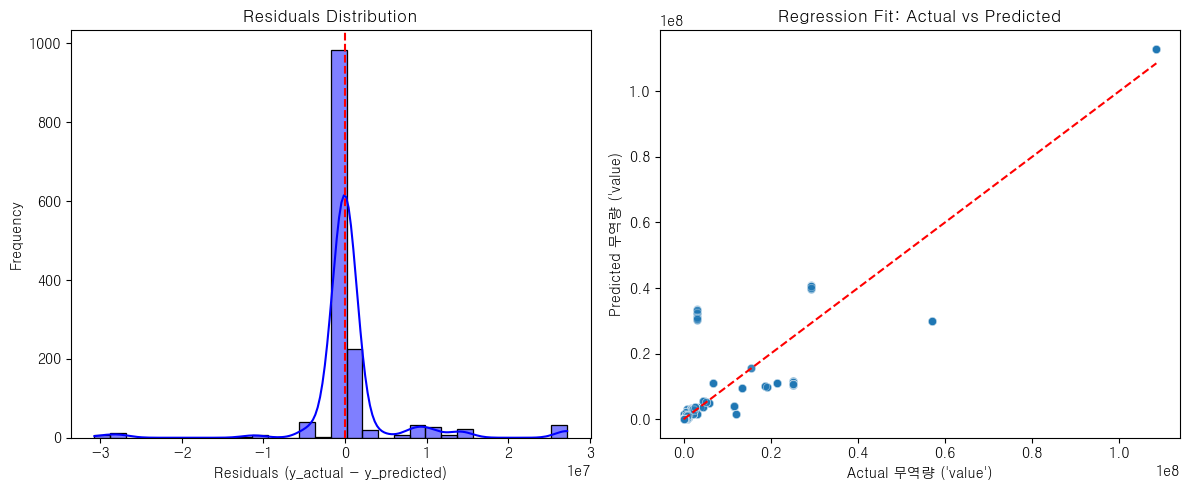

In [125]:
y_actual = y_true['value']
y_predicted = y_pred['value']

# Compute residuals.
residuals = y_actual - y_predicted


# Create plots.
plt.figure(figsize=(12,5))


# Plot 1: Residuals Distribution.
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals (y_actual - y_predicted)")
plt.ylabel("Frequency")


# Plot 2: Regression Fit (Actual vs Predicted).
plt.subplot(1,2,2)
sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.5)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual 무역량 ('value')")
plt.ylabel("Predicted 무역량 ('value)")


# Show plots.
plt.tight_layout()
plt.show()

## 7. 제출 파일 만들기
- pivot을 train, test로 split했던 것을 다시 합쳐서 Feat. Eng. 한 것 추가하고 재학습하여 최종 제출 파일을 만든다. 

In [126]:
# 1) 공햏성쌍 탐색 함수 파라미터 세팅 (default: min_lag=1, max_lag=6, min_nonzero=12, corr_threshold=0.4)
min_lag=1
max_lag=6 
min_nonzero=12 
corr_threshold=0.4

# 설정파라미터 로깅
#EXP_LOG = {} # 테스트 파라미터 값 저장 딕셔너리 ==> 일단 이건 고정하고, feat.eng.와 model에 변화주며 테스팅
EXP_LOG['min_lag'] = 1
EXP_LOG['max_lag'] = 6
EXP_LOG['min_nonzero'] = 12
EXP_LOG['corr_threshold'] = 0.4

# 2) LinearRegression 모델 파라미터 세팅(defaut: )

# 3) pivot 데이터프레임
pivot = pivot_org.copy()
print("pivot.shape: ", pivot.shape)
pivot.head(3)

pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# 4) 공행성쌍 with pivot_org
pairs = find_comovement_pairs(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
print("탐색된 공행성쌍 수:", len(pairs)) # 탐색된 공행성쌍 수: 1425

EXP_LOG["탐색된 공행성쌍 pairs.shape"] = pairs.shape
#pairs.head()

#####
##### Feature. Eng.
#####
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['wv_cat'] = pairs['following_item_id'].map(dct_wv_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['seq_cat'] = pairs['following_item_id'].map(dct_seq_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['hs4_cat'] = pairs['following_item_id'].map(dct_hs4_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

100it [00:07, 14.05it/s]

탐색된 공행성쌍 수: 1425


,leading_item_id,following_item_id,best_lag,max_corr,wv_cat,seq_cat,hs4_cat
0,AANGBULD,APQGTRMF,5,-0.443984,4,3,14
1,AANGBULD,DEWLVASR,6,0.640221,4,3,14
2,AANGBULD,DNMPSKTB,4,-0.410635,4,3,4


In [128]:
# 5) 학습 데이터 생성
df_train_model = build_training_data_fe(pivot_org, pairs, add_fe=['wv_cat', 'seq_cat', 'hs4_cat']) # 생성된 학습 데이터의 shape : (53318, 7) ->  (54743, 8) ->  (54743, 9)
print('생성된 학습 데이터의 shape :', df_train_model.shape)
display(df_train_model.head())
EXP_LOG['생성된 학습 데이터의 shape'] = df_train_model.shape

생성된 학습 데이터의 shape : (54743, 9)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,wv_cat,seq_cat,hs4_cat,target
0,582317.0,539873.0,14276.0,-0.443984,5.0,4.0,3.0,14.0,759980.0
1,759980.0,582317.0,52347.0,-0.443984,5.0,4.0,3.0,14.0,216019.0
2,216019.0,759980.0,53549.0,-0.443984,5.0,4.0,3.0,14.0,537693.0
3,537693.0,216019.0,0.0,-0.443984,5.0,4.0,3.0,14.0,205326.0
4,205326.0,537693.0,26997.0,-0.443984,5.0,4.0,3.0,14.0,169440.0


In [129]:
# 6) 회귀모델 학습
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat']
# feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat']
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat', 'hs4_cat']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values

# reg = LinearRegression()
# reg = DecisionTreeRegressor(random_state=42, min_samples_split=2, min_samples_leaf=1)
reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=5)
reg.fit(train_X, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [130]:
# 7) 모델 추론
#y_pred = predict(pivot, pairs, reg)
# y_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat'])
y_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat', 'hs4_cat'])

print("pivot.shape: ", pivot.shape) # (100, 42) -> (100, 43)
display(pivot.head(3))
print("pairs.shape: ", pairs.shape) # (1425, 4) -> (1425, 5)  -> (1425, 6)  -> (1425, 7)
display(pairs.head(3))
print("y_pred.shape: ", y_pred.shape) # y_pred.shape:  (1425, 3)
display(y_pred.head(3))

1425it [00:09, 144.73it/s]

pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


pairs.shape:  (1425, 7)


,leading_item_id,following_item_id,best_lag,max_corr,wv_cat,seq_cat,hs4_cat
0,AANGBULD,APQGTRMF,5,-0.443984,4,3,14
1,AANGBULD,DEWLVASR,6,0.640221,4,3,14
2,AANGBULD,DNMPSKTB,4,-0.410635,4,3,4


y_pred.shape:  (1425, 3)


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,93396
1,AANGBULD,DEWLVASR,365597
2,AANGBULD,DNMPSKTB,5341108


In [131]:
# 로깅한 주요파라미터들 
#print(f"EXP_LOG: {EXP_LOG}")

for k,v in EXP_LOG.items():
    print(f'{k} : {v}')

min_lag : 1
max_lag : 6
min_nonzero : 12
corr_threshold : 0.4
탐색된 공행성쌍 pairs.shape : (1425, 4)
공행성이 탐지되지 않은 상품수 : 9
공행성이 탐지되지 않은 상품id: : ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성이 탐지된 상품수 : 91
생성된 학습 데이터의 shape : (54743, 9)
local_exp_score : 0.797316894875888


In [132]:
# submit csv 생성
save_file_name = './data/local_test_LR_FE_wv_seq_hs4_20251117_hys.csv'

submission_submit = y_pred.copy()
submission_submit.to_csv(save_file_name, index=False)